# Boing de 2015 à la crise de 2020

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [254]:
def plot_corr_function(df):
    """
    Take a pandas series and plot Auto-correlation function and Partial Auto-correlation
    """
    fig, ax = plt.subplots(2, 1, figsize= [8, 6])
    
    _ = plot_acf(df, color= 'blue', ax= ax[0])
    _ = plot_pacf(df, color= 'blue', ax= ax[1])# _ = est un truc pour éviter d'imprimer 2x le même plot

In [125]:
def get_stationarity(timeseries, window_size= 12 ):
    """
    Take a pandas serie timeseries in to output key indicators of stationarity
    """    
    # rolling statistics
    rolling_mean = timeseries.rolling(window= window_size).mean()
    rolling_std = timeseries.rolling(window= window_size).std()

    # rolling statistics plot
    fig= plt.figure(figsize= (15, 4))
    original = plt.plot(timeseries, color='black', label='Original', alpha= 0.3)
    mean = plt.plot(rolling_mean, color='coral', label='Rolling Mean')
    std = plt.plot(rolling_std, color='teal', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print("Mean MinMax Delta:", rolling_mean.max() - rolling_mean.min())
    print("Std MinMax Delta:", rolling_std.max() - rolling_std.min())
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [661]:
def tfrm_to_MinusMean(PdSeries, window_size= 12):
    """
    Transform a Pandas Series to stationary by substracting value from a rolling mean (deviation from mean).
    Returns a Pandas Series
    
    See why here: (https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
    """
    
    df_ravg = PdSeries.rolling(window_size).mean()
    df_minus_mean = PdSeries - df_ravg
    df_minus_mean.dropna(inplace=True)
    return df_minus_mean, df_ravg

In [568]:
def AIC(PdSeries, order= (1,1)):
    """
    Take a Pandas series and fit an ARMA model of order= 
    to return Akaike Information Criterion
    """

    # Fit the data to an AR(1) model and print AIC:
    mod_arma = ARMA(PdSeries, order= order)
    res_arma = mod_arma.fit()
    print("The AIC for an ARMA{} is: {:5.0f} ".format(order, res_arma.aic))
    return res_arma.aic

In [190]:
def aic_optimize(PdSeries, ar_max_range= 8, ma_max_range= 12):
    """
    Take Pandas series and print Akaike Information Criterion for every order in 
    a range of order, ar(0) to ar(ar_max_range) and ma(0) to ma(ma_max_range).
    Also return a list of all AIC values. 
    """
    ar_ls= np.arange(0, ar_max_range)
    ma_ls= np.arange(0, ma_max_range)
    aic_ls= []
    for i in ar_ls:
        for j in ma_ls:
            aic = AIC(PdSeries, order= (i, j))
            aic
            aic_ls.append(aic)
    return aic_ls

In [273]:
def rolling_window(a, step):
    shape   = a.shape[:-1] + (a.shape[-1] - step + 1, step)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [553]:
def rolwin_ARIMA(df, ARIMA_order= (1,0,1), window_size= 100):
    """
    Take a DataFrame and train an ARIMA model on a rolling window to get
    the predicted value, one data point beyond the window.
    
    Returns a DataFrame to compare actual data VS predicted
    """
    
    output_df = pd.DataFrame(df.iloc[window_size : :])
    
    # Créer une liste de np.arrays de valeurs n=100 d'une fenêtre roulante
    r = rolling_window(np.array(df), window_size)

    # Init d'une liste de prédictions
    pred_col = []

    for i in r:
        mod_arma_t = ARIMA(i, order= ARIMA_order)
        res_arma_t = mod_arma_t.fit()

        # Prédire 1 jour au-delà du dataset
        pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
        # Ajouter la prédiction à la liste
        pred_col.append(pred_arma_t[window_size]) 

    output_df['Prediction'] = pred_col[0:-1]
    output_df['Erreur'] = output_df['Adj Close'] - output_df['Prediction']
    
    return output_df

In [834]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [2]:
BA = pd.read_csv('Aero_analysis - BA.csv', parse_dates= True)
BA.index = pd.to_datetime(BA.Date)
BA = BA.drop(columns= ['Date', 'Column1', 'Historical', 'Unnamed: 12', 'Unnamed: 13' ])

In [3]:
BA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-04-28 to 2020-04-27
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1259 non-null   float64
 1   High              1259 non-null   float64
 2   Low               1259 non-null   float64
 3   Close             1259 non-null   float64
 4   Adj Close         1259 non-null   float64
 5   Volume            1259 non-null   int64  
 6   Average           1259 non-null   float64
 7   Relative to mean  1259 non-null   float64
 8   % increase        1258 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 98.4 KB


In [4]:
BA.head()

,Open,High,Low,Close,Adj Close,Volume,Average,Relative to mean,% increase
Date,,,,,,,,,
2015-04-28,147.899994,148.369995,146.009995,147.509995,128.818481,4352900,147.189995,0.597664,0.207083
2015-04-29,147.070007,147.460007,145.899994,146.149994,127.630844,4761700,146.680000,0.595594,0.948126
2015-04-30,145.250000,145.940002,142.750000,143.339996,125.176880,4925300,144.345001,0.586112,-0.044666
2015-05-01,144.410004,145.070007,143.839996,144.669998,126.338371,3556800,144.455001,0.586559,0.190847
2015-05-04,143.850006,144.789993,143.179993,144.020004,125.770737,8977500,143.984993,0.584651,0.203022


### Boing de 2015 à 2019

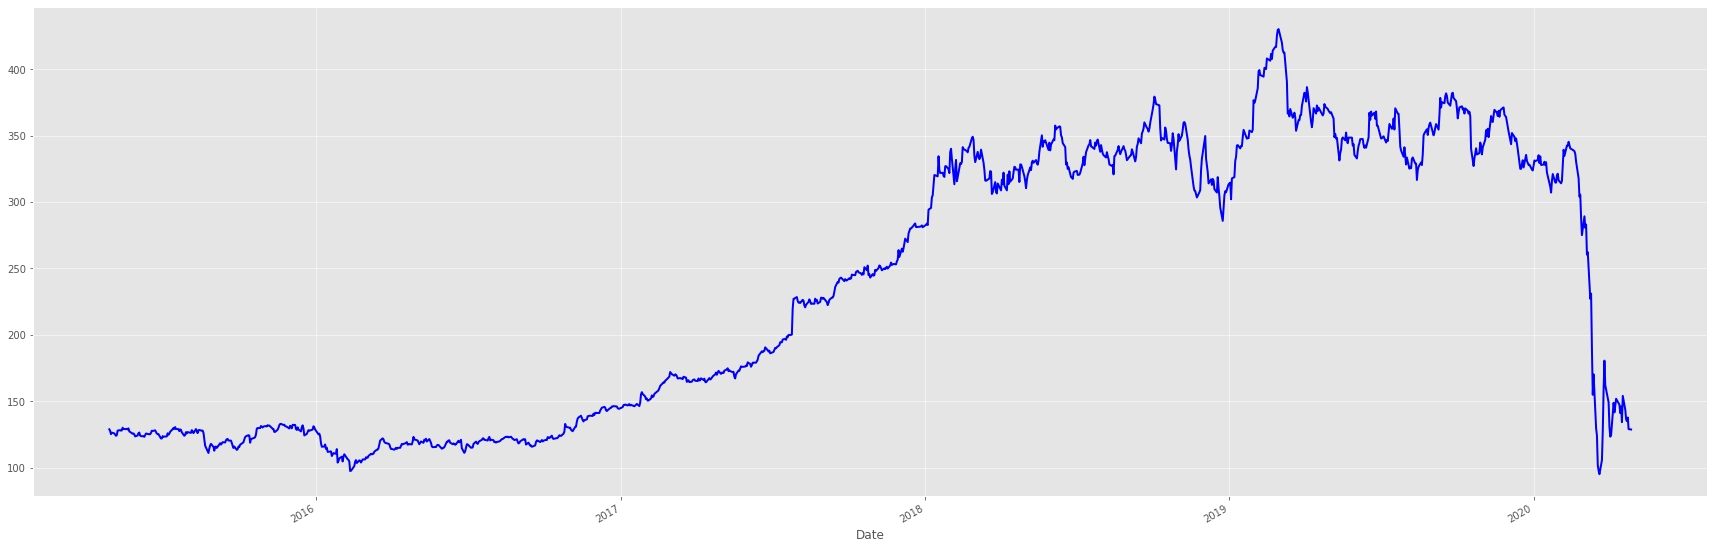

In [102]:
_ = BA['Adj Close'].plot(color= 'blue', figsize= [30, 10])

## Recherche de la transformation significative et optimale

### Boing 2016 - Différenciation des valeurs

In [34]:
BA_diff = BA['Adj Close'].diff()
BA_diff.dropna(inplace= True)

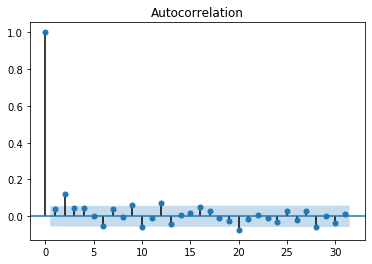

In [57]:
_ = plot_acf(BA_diff) # _ = est un truc pour éviter d'imprimer 2x le même plot

In [3]:
BA_2016 = BA.loc['2016']

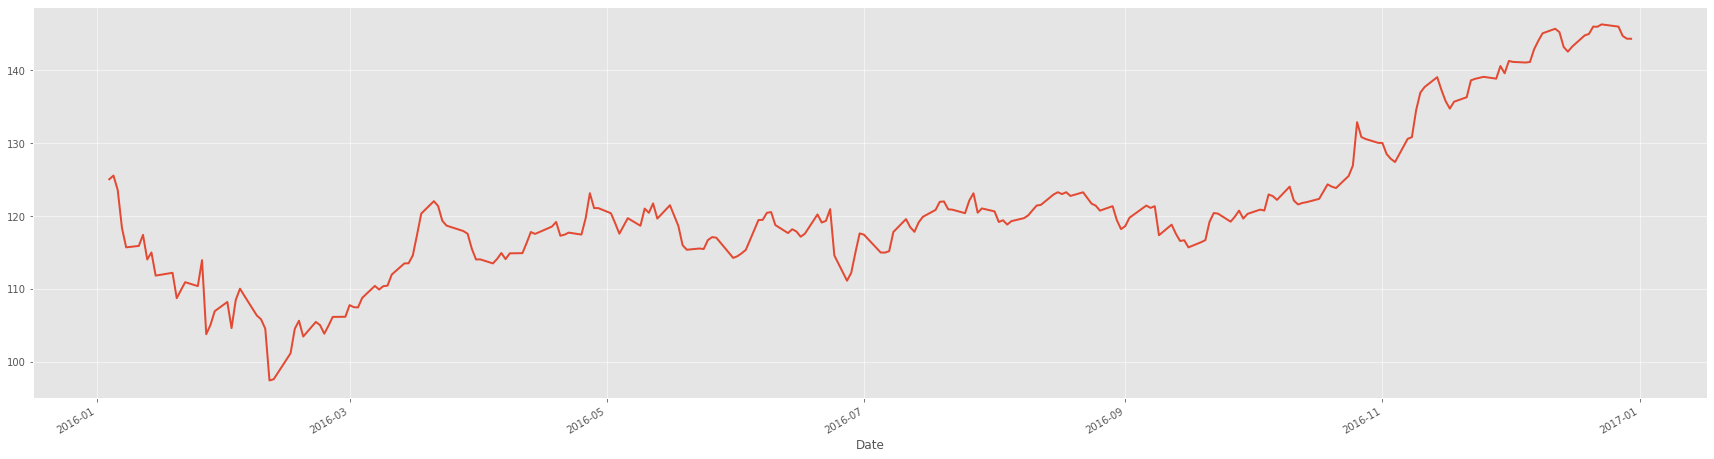

In [124]:
_ = BA_2016['Adj Close'].plot(figsize= [30, 8])

### Valeurs différenciées sur interval de 1 jours ("First difference")

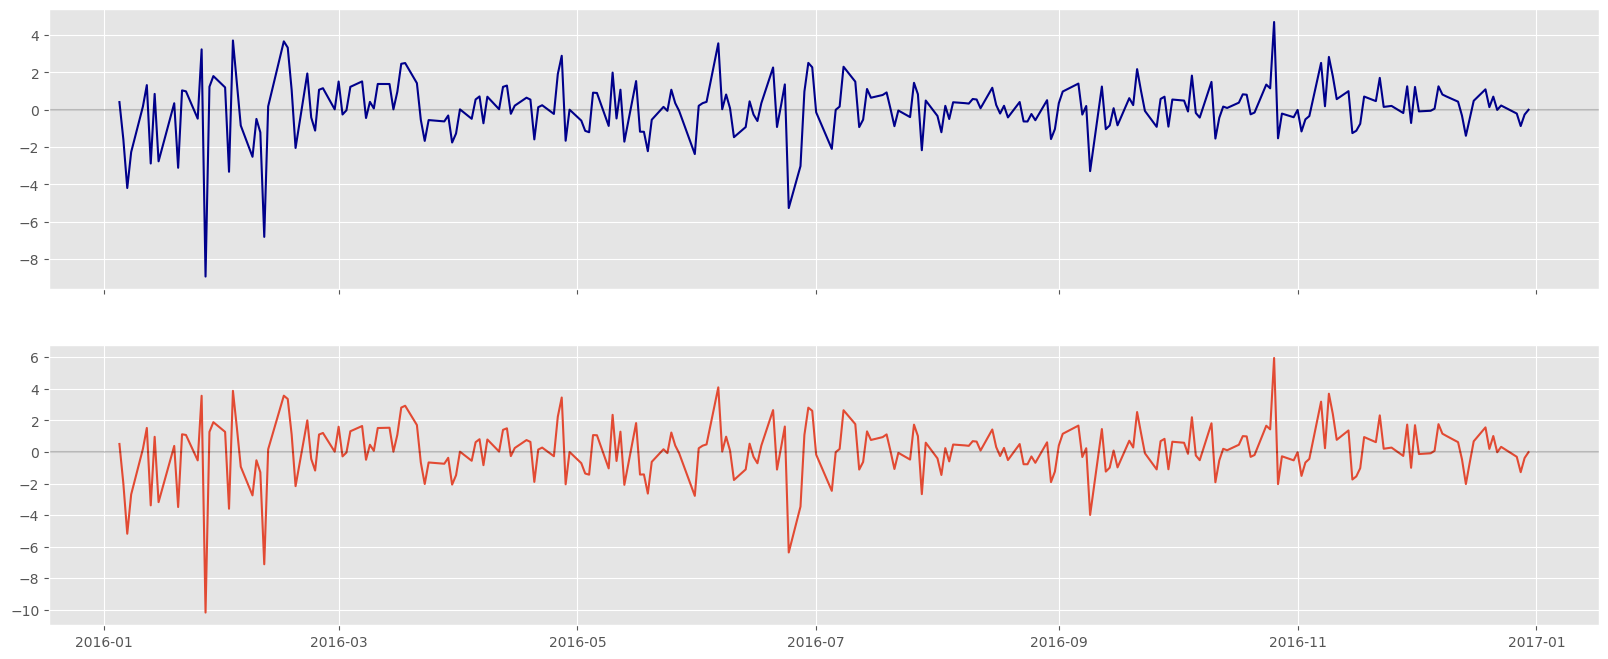

In [651]:
BA_2016_diff = BA_2016['Adj Close'].diff()
BA_2016_pct = BA_2016['Adj Close'].pct_change()*100
BA_2016_diff.dropna(inplace= True)
BA_2016_pct.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct.index, BA_2016_pct, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff.index, BA_2016_diff)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

#### Est-ce un random walk?

In [653]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_pct)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("Le adf p-value est de: {:.15f}".format(adf[1]))

Le adf p-value est de: 0.000000000000096


L'hypothèse nul peut être rejetée. 
Le court de Boing n'est `PAS`un random walk.

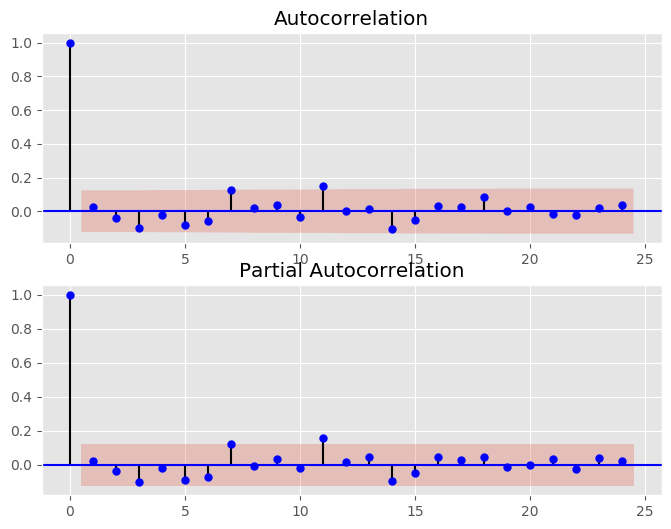

In [457]:
plot_corr_function(BA_2016_pct)

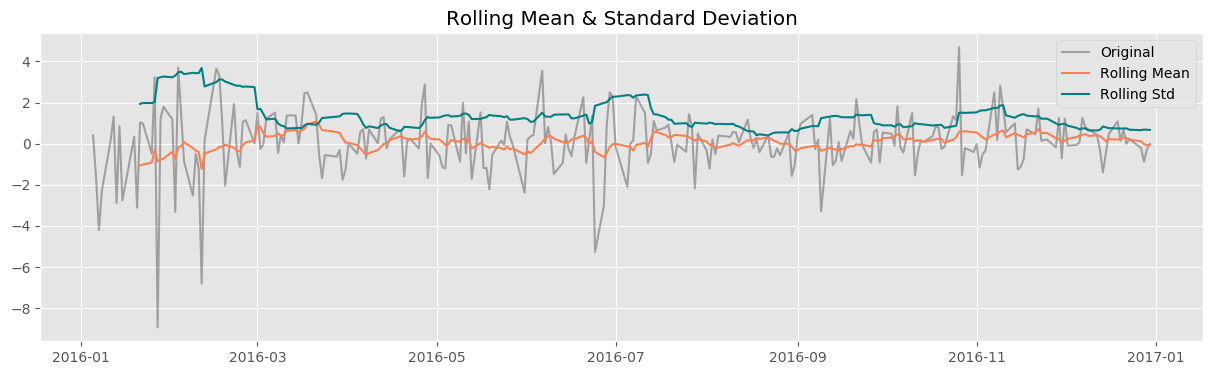

Mean MinMax Delta: 2.3039650821884647
Std MinMax Delta: 3.2886571819465447
ADF Statistic: -8.544188414724577
p-value: 9.601787693620281e-14
Critical Values:
	1%: -3.457215237265747
	5%: -2.873361841566324
	10%: -2.5730700760129555


In [654]:
get_stationarity(BA_2016_pct)

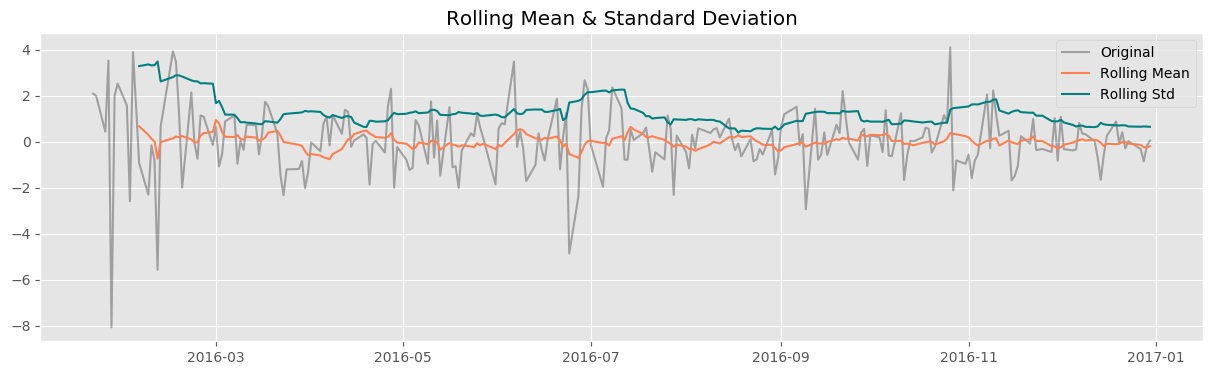

Mean MinMax Delta: 1.7038971424436808
Std MinMax Delta: 3.0897914556339314
ADF Statistic: -9.445063719672689
p-value: 4.780069701192316e-16
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


In [655]:
# Transform to stationary x - rolling mean
BA_2016_pct_minus_mean = tfrm_to_MinusMean(BA_2016_pct)
# Assess transformed dataset performances
get_stationarity(BA_2016_pct_minus_mean)

L'échantillon 2016 différencier % de 1 - le rolling avg est hautement stationnaire.

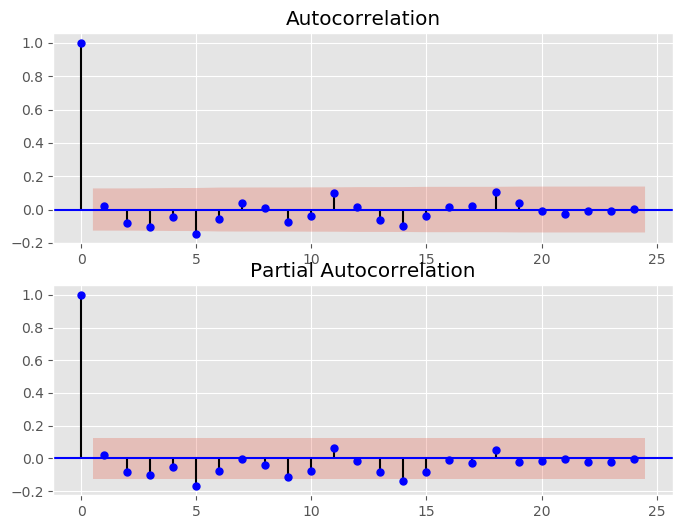

In [461]:
plot_corr_function(BA_2016_pct_minus_mean)

L'échantillon 2016 différencier % de 1 + meanDev (- le rolling avg )
n'a aucune auto-corellation significative. L'ordre de AR optimal n'est donc pas important (Partial Autocorrolation).

### Valeurs différenciées sur interval de 4 jours

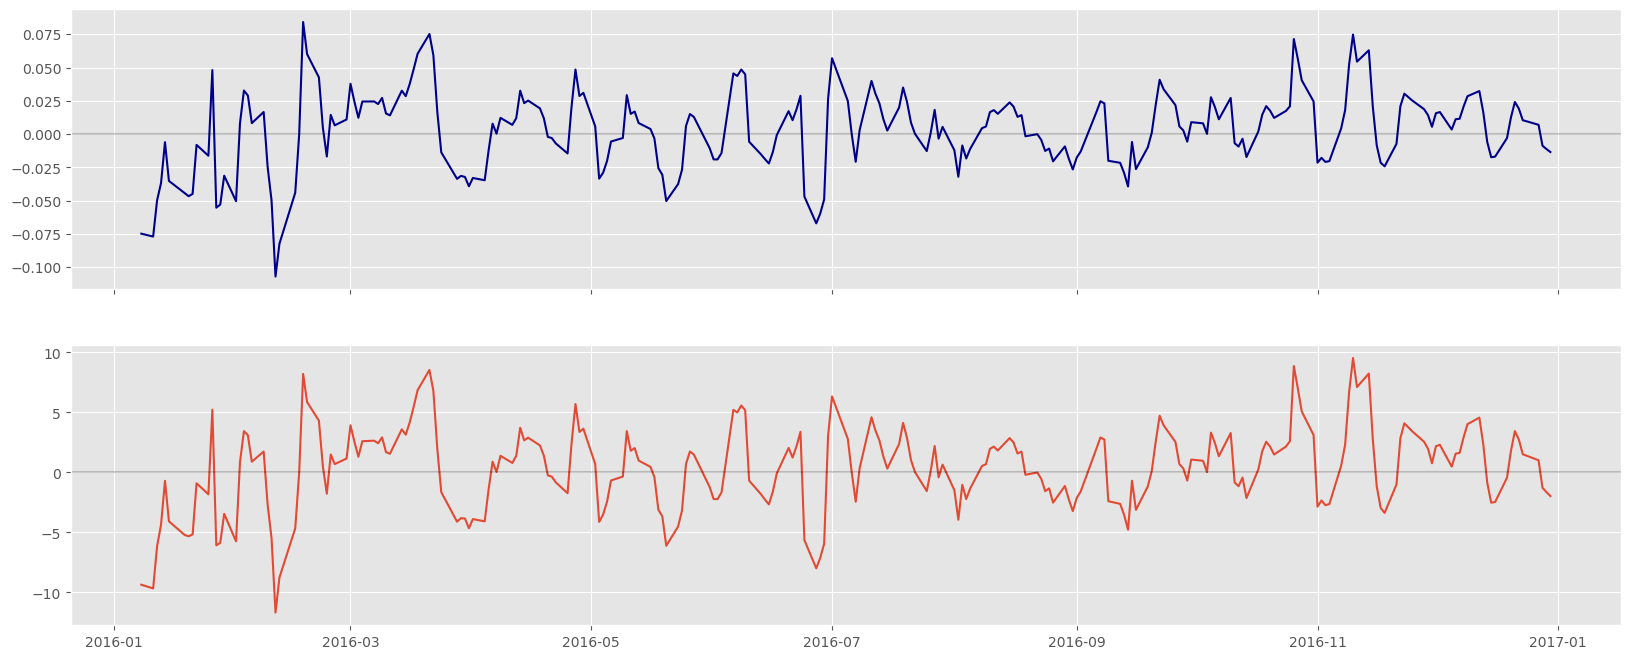

In [462]:
BA_2016_diff4 = BA_2016['Adj Close'].diff(4)
BA_2016_pct4 = BA_2016['Adj Close'].pct_change(4)
BA_2016_diff4.dropna(inplace= True)
BA_2016_pct4.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct4.index, BA_2016_pct4, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff4.index, BA_2016_diff4)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

#### Est-ce un random walk?

In [646]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_pct4)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("le adf p-value est de: {:.5f}".format(adf[1]))

le adf p-value est de: 0.00417


L'hypothèse nul peut être rejetée. 
Le court de Boing diff 4 n'est `PAS`un random walk.

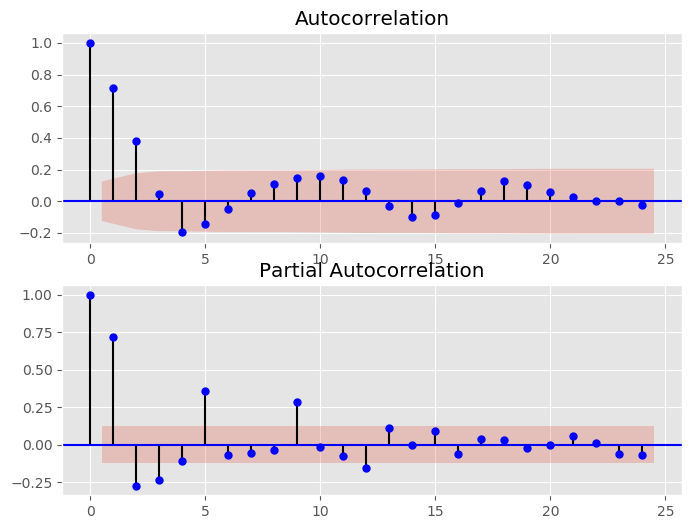

In [464]:
plot_corr_function(BA_2016_pct4)

### Valeurs différenciées sur interval de 5 jours

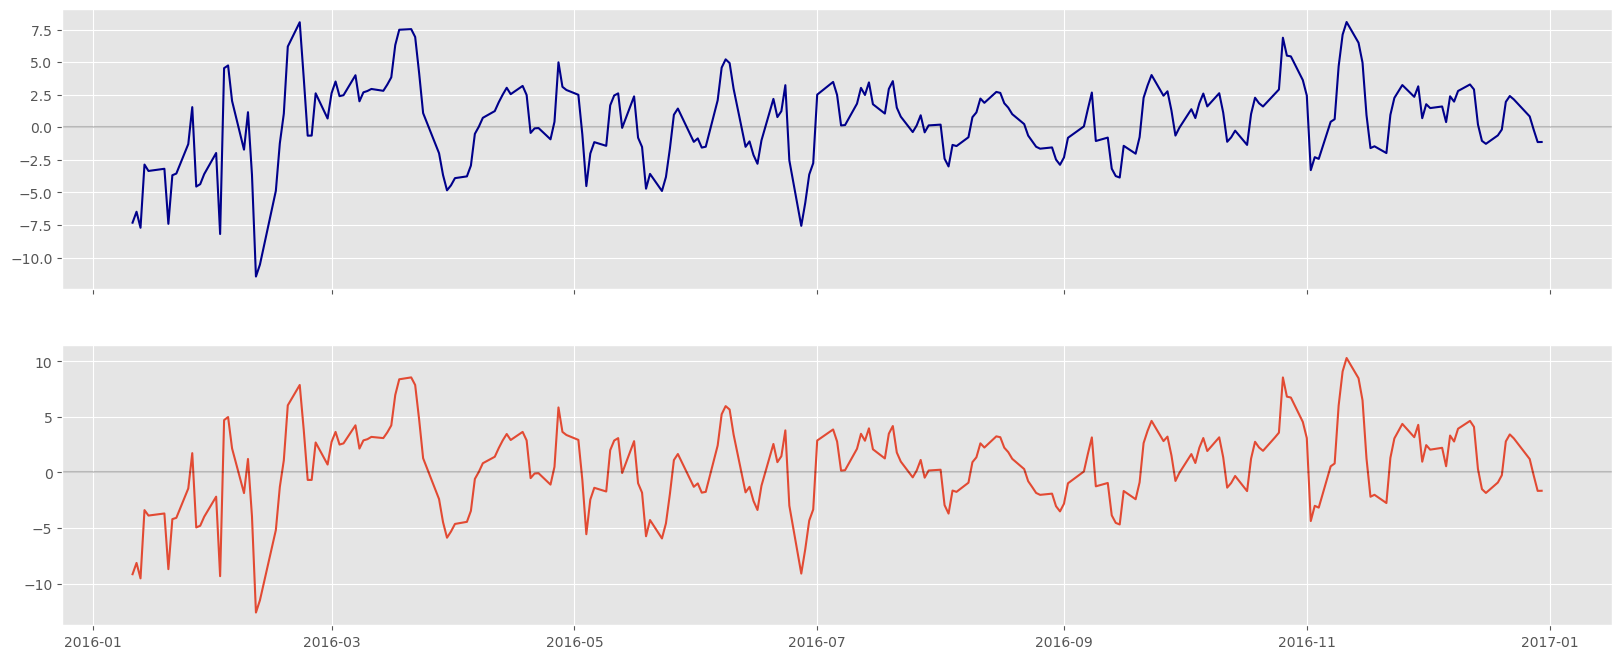

In [486]:
BA_2016_diff5 = BA_2016['Adj Close'].diff(5)
BA_2016_diff5.dropna(inplace= True)
# Tranform to stationary returns with seasonal of 5
BA_2016_pct5 = BA_2016['Adj Close'].pct_change(5)*100
BA_2016_pct5.dropna(inplace= True)

fig, ax = plt.subplots(2, 1, sharex= True, figsize= [20, 8])
plt.style.use("ggplot")

_ = ax[0].plot(BA_2016_pct5.index, BA_2016_pct5, color= 'darkblue')
_ = ax[1].plot(BA_2016_diff5.index, BA_2016_diff5)
_ = ax[0].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)
_ = ax[1].axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

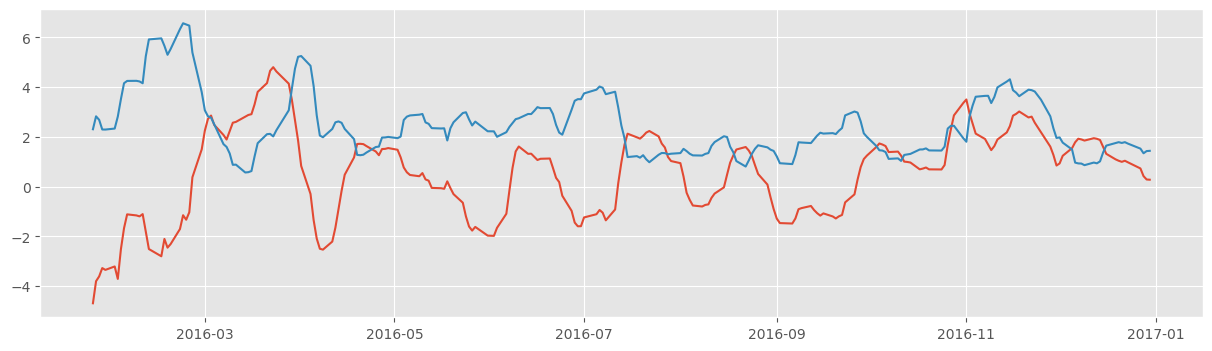

In [487]:
# See get_stationarity function below for more complete output.
BA_2016_pct5_ravg = BA_2016_pct5.rolling(10).mean()
BA_2016_pct5_rstd = BA_2016_pct5.rolling(10).std()
fig= plt.figure(figsize= (15, 4))
_ = plt.plot(BA_2016_pct5_ravg)
_ = plt.plot(BA_2016_pct5_rstd)

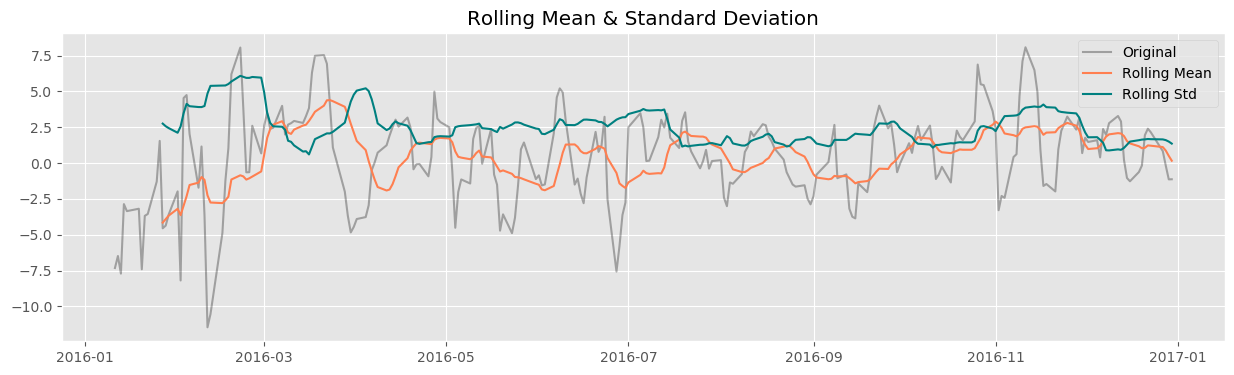

Mean MinMax Delta: 8.549807254870299
Std MinMax Delta: 5.485854922031832
ADF Statistic: -3.1357815577065926
p-value: 0.02401604072338551
Critical Values:
	1%: -3.459105583381277
	5%: -2.8741898504150574
	10%: -2.5735117958412097


In [488]:
get_stationarity(BA_2016_pct5)

### Pct5 meanDev (minus rolling mean) transformation

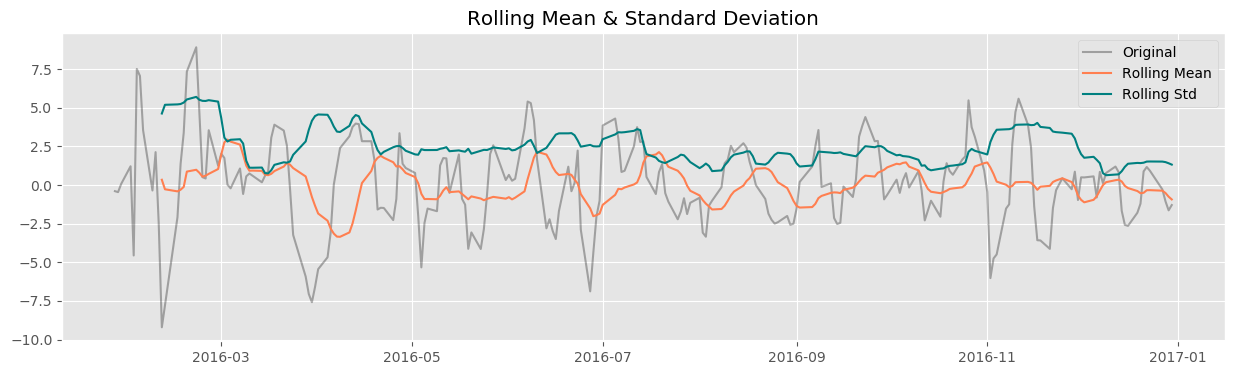

Mean MinMax Delta: 6.292429398582387
Std MinMax Delta: 5.069726896213904
ADF Statistic: -4.069478765898636
p-value: 0.0010873569647315829
Critical Values:
	1%: -3.4604283689894815
	5%: -2.874768966942149
	10%: -2.57382076446281


In [494]:
# Transform to stationary x - rolling mean deviation
BA_2016_pct5_meanDev = tfrm_to_MinusMean(BA_2016_pct5)
# Assess transformed dataset performances
get_stationarity(BA_2016_pct5_meanDev)

#### Est-ce un random walk?

In [645]:
# Appliquer le Dickey-Fuller test pour voir si c'est un random walk.
adf = adfuller(BA_2016_pct5)
# Cette valeur (p-value) @ moins de 0.05 permet de rejeter l'hypothèse nul
print("Le adf p-value est de: {:.5f}".format(adf[1]))

Le adf p-value est de: 0.02402


L'hypothèse nul peut être rejetée. 
Le court de Boing diff 5 n'est `PAS`un random walk.

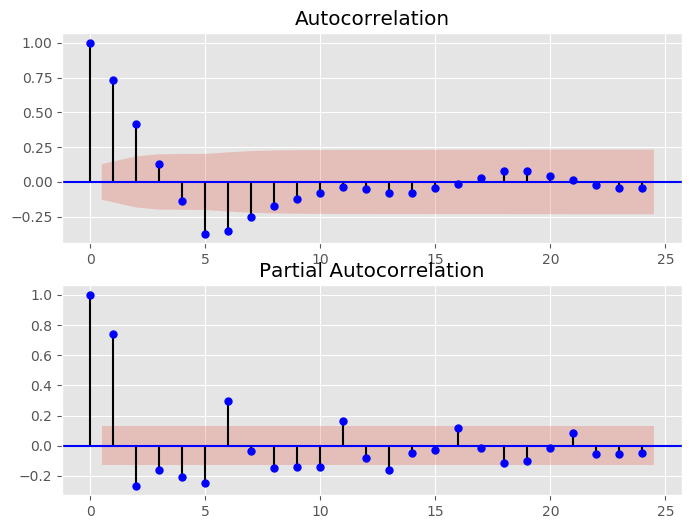

In [496]:
plot_corr_function(BA_2016_pct5_meanDev)

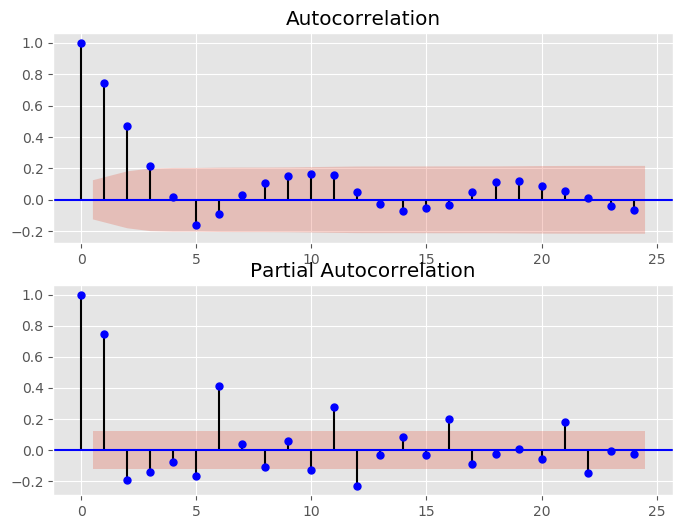

In [470]:
plot_corr_function(BA_2016_pct5)

### PCT5 avec Exponential decay

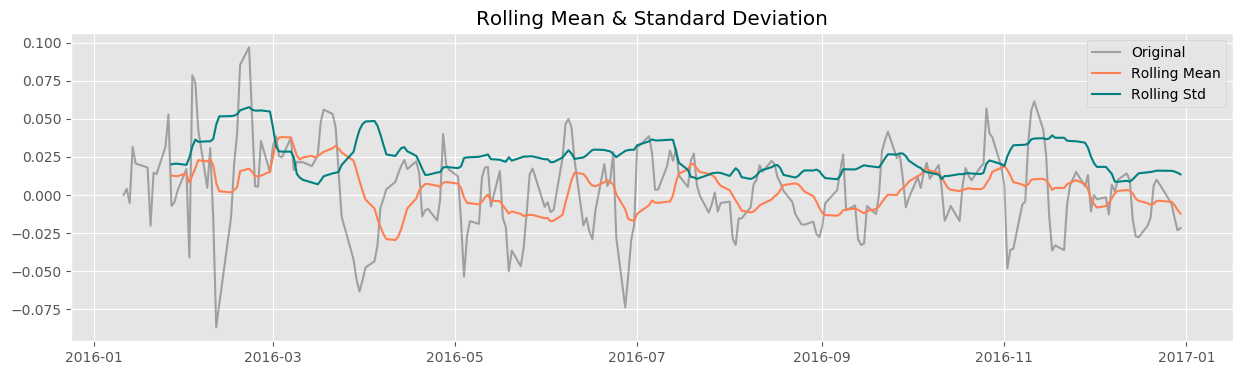

Mean MinMax Delta: 0.06757657314532635
Std MinMax Delta: 0.05065799823140337
ADF Statistic: -3.448021096478882
p-value: 0.00942678577415559
Critical Values:
	1%: -3.459105583381277
	5%: -2.8741898504150574
	10%: -2.5735117958412097


In [471]:
rolling_mean_exp_decay = BA_2016_pct5.ewm(halflife=12, min_periods=0, adjust=True).mean()
BA_2016_pct5_exp_decay = BA_2016_pct5 - rolling_mean_exp_decay
BA_2016_pct5_exp_decay.dropna(inplace=True)
get_stationarity(BA_2016_pct5_exp_decay)

Non probant

### Log + exponential decay

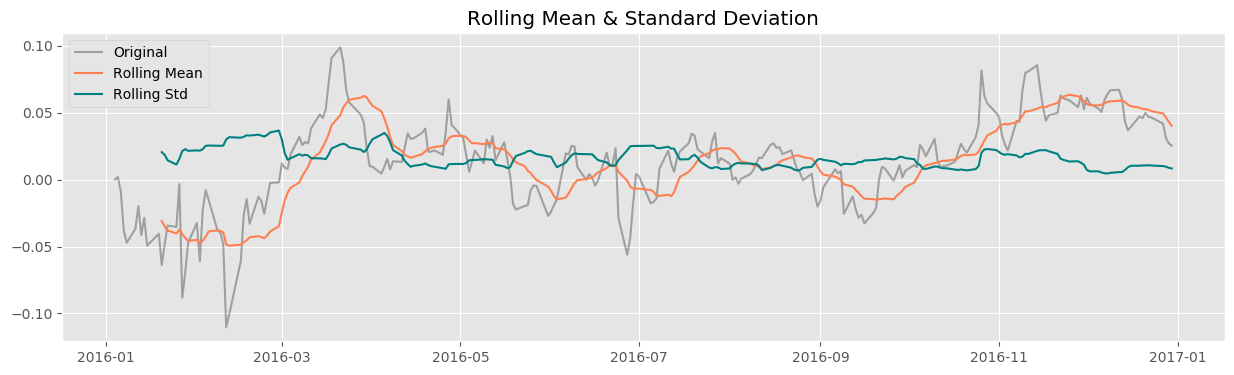

Mean MinMax Delta: 0.11277377173798309
Std MinMax Delta: 0.03205387309402805
ADF Statistic: -2.5150829147004607
p-value: 0.11184748603963374
Critical Values:
	1%: -3.457215237265747
	5%: -2.873361841566324
	10%: -2.5730700760129555


In [472]:
BA_2016_pct_log = np.log(BA_2016['Adj Close'])
rolling_mean_exp_decay = BA_2016_pct_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
BA_2016_pct_log_exp_decay = BA_2016_pct_log - rolling_mean_exp_decay
#BA_2016_diff_log_exp_decay.dropna(inplace=True)
get_stationarity(BA_2016_pct_log_exp_decay)

Non probant

## Recherche des paramètres ARMA optimales

### Akaike Information Criterion comme loss function à minimiser
Trouver le paramètre optimal en minimisant le loss function (ici le AIC)

In [557]:
#BA_2016_pct5.index = pd.DatetimeIndex(BA_2016_pct5.index).to_period('W') # Nécessaire pour forcaster

print('BA_2016 différence de % de 5')

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(BA_2016_pct5, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

mod_ar2 = ARMA(BA_2016_pct5, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

mod_ar6 = ARMA(BA_2016_pct5, order=(6, 0))
res_ar6 = mod_ar6.fit()
print("The AIC for an AR(6) is: ", res_ar6.aic)

mod_arma11 = ARMA(BA_2016_pct5, order=(1, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

mod_arma61 = ARMA(BA_2016_pct5, order=(6, 1))
res_arma61 = mod_arma61.fit()
print("The AIC for an ARMA(6,1) is: ", res_arma61.aic)

mod_arma62 = ARMA(BA_2016_pct5, order=(6, 2))
res_arma62 = mod_arma62.fit()
print("The AIC for an ARMA(6,2) is: ", res_arma62.aic)

mod_arma63 = ARMA(BA_2016_pct5, order=(6, 3))
res_arma63 = mod_arma63.fit()
print("The AIC for an ARMA(6,3) is: ", res_arma63.aic)
print(res_arma63.arparams)

mod_arma33 = ARMA(BA_2016_pct5, order=(3, 3))
res_arma33 = mod_arma33.fit()
print("The AIC for an ARMA(3,3) is: ", res_arma33.aic)

BA_2016 différence de % de 5
The AIC for an AR(1) is:  1069.3890998977547
The AIC for an AR(2) is:  1061.86111028426
The AIC for an AR(6) is:  1007.8767502930812
The AIC for an ARMA(1,1) is:  1064.3505631109426
The AIC for an ARMA(6,1) is:  1009.1441115683888
The AIC for an ARMA(6,2) is:  997.8824857385599
The AIC for an ARMA(6,3) is:  990.3006337163781
[ 8.79103121e-01 -5.27461331e-01  8.60115727e-04  3.24973673e-01
 -4.92348957e-01  2.86821109e-01]
The AIC for an ARMA(3,3) is:  1014.7325256395362


In [559]:
print('BA_2016 différence de % de 5 et meanDev', '\n')

_= AIC(BA_2016_pct5_meanDev, order=(1, 0))
_= AIC(BA_2016_pct5_meanDev, order=(2, 0))
_= AIC(BA_2016_pct5_meanDev, order=(2, 3))
_= AIC(BA_2016_pct5_meanDev, order=(6, 0))
_= AIC(BA_2016_pct5_meanDev, order=(1, 1))
_= AIC(BA_2016_pct5_meanDev, order=(6, 1))
_= AIC(BA_2016_pct5_meanDev, order=(6, 2))
_= AIC(BA_2016_pct5_meanDev, order=(6, 3))
_= AIC(BA_2016_pct5_meanDev, order=(3, 3))
_= AIC(BA_2016_pct5_meanDev, order=(11, 3))

BA_2016 différence de % de 5 + variance 

The AIC for an ARMA(1, 0) is:  981.4427183380886
The AIC for an ARMA(2, 0) is:  967.0975536147205
The AIC for an ARMA(2, 3) is:  930.7144837642292
The AIC for an ARMA(6, 0) is:  916.0999029600644
The AIC for an ARMA(1, 1) is:  971.9514437720659
The AIC for an ARMA(6, 1) is:  917.0279955470055
The AIC for an ARMA(6, 2) is:  917.4395824197873
The AIC for an ARMA(6, 3) is:  896.1301477630678
The AIC for an ARMA(3, 3) is:  927.1653595821969
The AIC for an ARMA(11, 3) is:  883.5422435185712


In [499]:
_ = AIC(BA_2016_pct5_meanDev, order=(11, 2))

The AIC for an ARMA(11, 2) is:  882.0644490169502


In [501]:
_ = AIC(BA_2016_pct5_meanDev, order=(1, 6))

The AIC for an ARMA(1, 6) is:  846.0902019266462


In [572]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = aic_optimize(BA_2016_pct5_meanDev, ar_max_range= 5, ma_max_range= 11)

The AIC for an ARMA(0, 0) is:  1162 
The AIC for an ARMA(0, 1) is:  1031 
The AIC for an ARMA(0, 2) is:   973 
The AIC for an ARMA(0, 3) is:   972 
The AIC for an ARMA(0, 4) is:   861 
The AIC for an ARMA(0, 5) is:   863 
The AIC for an ARMA(0, 6) is:   860 
The AIC for an ARMA(0, 7) is:   857 
The AIC for an ARMA(0, 8) is:   858 
The AIC for an ARMA(0, 9) is:   851 
The AIC for an ARMA(0, 10) is:   852 
The AIC for an ARMA(1, 0) is:   981 
The AIC for an ARMA(1, 1) is:   972 
The AIC for an ARMA(1, 2) is:   971 
The AIC for an ARMA(1, 3) is:   966 
The AIC for an ARMA(1, 4) is:   863 
The AIC for an ARMA(1, 5) is:   846 
The AIC for an ARMA(1, 6) is:   846 
The AIC for an ARMA(1, 7) is:   848 
The AIC for an ARMA(1, 8) is:   850 
The AIC for an ARMA(1, 9) is:   849 
The AIC for an ARMA(1, 10) is:   850 
The AIC for an ARMA(2, 0) is:   967 
The AIC for an ARMA(2, 1) is:   951 
The AIC for an ARMA(2, 2) is:   953 
The AIC for an ARMA(2, 3) is:   931 
The AIC for an ARMA(2, 4) is:   861 

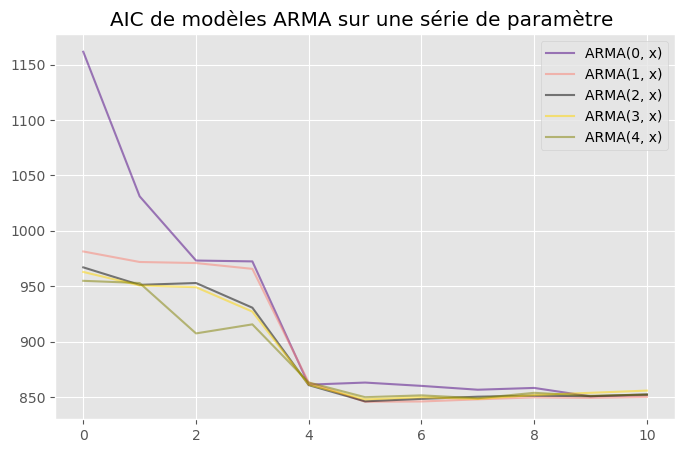

In [562]:
plt.figure(figsize= (8, 5))
_= plt.plot(aic_16_5_var[0:11], color='indigo', label='ARMA(0, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[11:22], color='salmon', label='ARMA(1, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[22:33], color='black', label='ARMA(2, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[33:44], color='gold', label='ARMA(3, x)', alpha= 0.5)
_= plt.plot(aic_16_5_var[44:55], color='olive', label='ARMA(4, x)', alpha= 0.5)
_= plt.legend(loc='best')
_= plt.title('AIC de modèles ARMA sur une série de paramètres ')

In [574]:
print("L'AIC optimal est: {:5.0f}".format(min(aic_16_5_var)))

L'AIC optimal est:   846


ARMA(1,5)

## On-step prediction sur un rolling window de valeurs historiques

### Mise au point du rolling window

In [507]:
r = rolling_window(np.array(BA_2016_pct5_meanDev), 100)
r.shape

(137, 100)

In [592]:
print('{:.3f}, {:.3f}, {:.3f}, {:.3f}'.format(r[0][0], r[1][0], r[2][0], r[3][0]))

-0.396, -0.458, 0.074, 1.215


In [509]:
BA_2016_pct5_meanDev.head()

Date
2016-01-27   -0.395910
2016-01-28   -0.457966
2016-01-29    0.073807
2016-02-01    1.215154
2016-02-02   -4.559695
Name: Adj Close, dtype: float64

In [510]:
BA_2016_pct5_meanDev.shape

(236,)

In [511]:
# print(r[0][0:10])
print(BA_2016_pct5_meanDev.iloc[101:116])

Date
2016-06-21   -0.399940
2016-06-22    0.125174
2016-06-23    2.231846
2016-06-24   -2.894954
2016-06-27   -6.882093
2016-06-28   -4.383446
2016-06-29   -2.032384
2016-06-30   -1.021066
2016-07-01    3.853257
2016-07-05    4.304216
2016-07-06    3.011811
2016-07-07    0.845250
2016-07-08    0.923926
2016-07-11    2.518628
2016-07-12    3.748161
Name: Adj Close, dtype: float64


In [593]:
mod_arma_t = ARIMA(r[0], order= (1,0,5)) # Trainé un modèle sur la fenêtre #0
res_arma_t = mod_arma_t.fit()
pred_arma_t = res_arma_t.predict(end= len(r[0]) + 1)
print('{:.3f}'.format(pred_arma_t[101]))

-0.206


In [594]:
mod_arma_t = ARIMA(r[15], order= (1,0,5)) # Trainé un modèle sur la fenêtre #15
res_arma_t = mod_arma_t.fit()

# Predict  days after training
pred_arma_t = res_arma_t.predict(end= len(r[15]) + 1)
print('{:.3f}'.format(pred_arma_t[100]))

2.769


In [525]:
len(pred_arma_t)
pred_arma_t[101]

2.8725838555802983

## One-step forecast

### Mise au point d'un DataFrame pour comparer les valeur prédites vs les valeurs historiques

In [532]:
# Créer un df à partir de l'entré #100 pour compenser le rolling window.
BA_2016_pct5_meanDev_pred = pd.DataFrame(BA_2016_pct5_meanDev.iloc[100::])

# Créer une liste de np.arrays de valeurs n=100 d'une fenêtre roulante
r = rolling_window(np.array(BA_2016_pct5_meanDev), 100)

# Init d'une liste de prédictions
pred_col = []

for i in r:
    mod_arma_t = ARIMA(i, order= (1,0,5))
    res_arma_t = mod_arma_t.fit()
    
    # Prédire 1 jour au-delà du dataset
    pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
    # Ajouter la prédiction à la liste
    pred_col.append(pred_arma_t[100]) 
    
BA_2016_pct5_meanDev_pred['Prediction'] = pred_col[0:-1]
BA_2016_pct5_meanDev_pred['Erreur'] = BA_2016_pct5_meanDev_pred['Adj Close'] - BA_2016_pct5_meanDev_pred['Prediction']

In [541]:
BA_2016_pct5_meanDev_pred

,Adj Close,Prediction,Delta_REELvsPRED
Date,,,
2016-06-20,1.186224,-0.194232,1.380456
2016-06-21,-0.399940,0.769234,-1.169174
2016-06-22,0.125174,0.465439,-0.340266
2016-06-23,2.231846,0.986427,1.245419
2016-06-24,-2.894954,1.655745,-4.550699
...,...,...,...
2016-12-23,0.930929,0.769600,0.161328
2016-12-27,-0.284424,0.324260,-0.608684
2016-12-28,-1.054649,0.492951,-1.547599


### Exploration graphique des premiers résultats

Moyenne du delta Réel vs Prédiction: -0.008 
Écart type du delta Réel vs Prédiction: 1.159
Écart type des données: 2.293


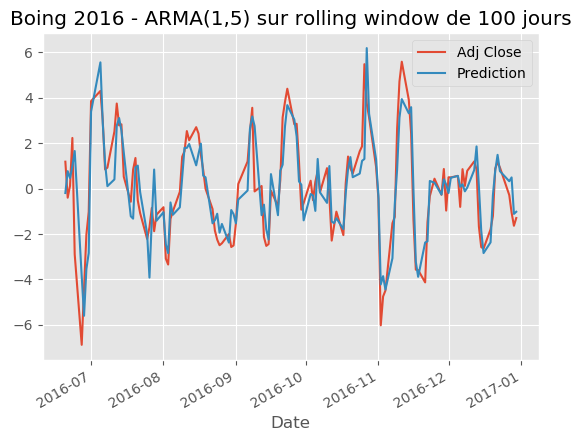

In [658]:
print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(BA_2016_pct5_meanDev_pred['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}".format(BA_2016_pct5_meanDev_pred['Erreur'].std()))
print("Écart type des données: {:.3f}".format(BA_2016_pct5_meanDev_pred['Adj Close'].std()))
_= BA_2016_pct5_meanDev_pred[['Adj Close', 'Prediction']].plot()
_= plt.title('Boing 2016 - ARMA(1,5) sur rolling window de 100 jours')

In [835]:
forecast_accuracy(BA_2016_pct5_meanDev_pred['Erreur'], BA_2016_pct5_meanDev_pred['Adj Close'])

{'mape': 1.996155160431836,
 'me': -0.015205425546572037,
 'mae': 1.5746438182235172,
 'mpe': 0.34990758876067857,
 'rmse': 2.031808284247016,
 'corr': 0.4595612788272259,
 'minmax': 1.749972941204741}

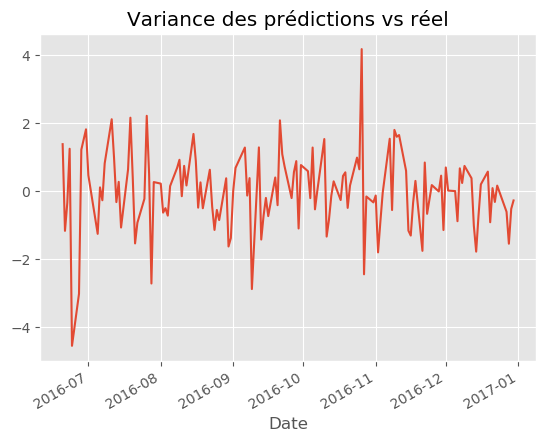

In [659]:
_ = BA_2016_pct5_meanDev_pred['Erreur'].plot()
_= plt.title('meanDev des prédictions vs réel')

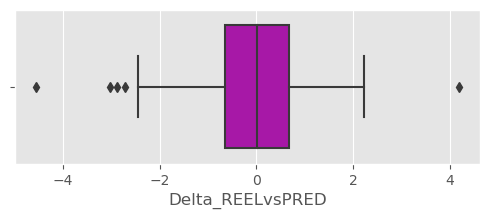

In [538]:
fig= plt.figure(figsize= (6, 2))
_ = sns.boxplot(x= 'Erreur', palette=["m", "g"],
            data= BA_2016_pct5_meanDev_pred)

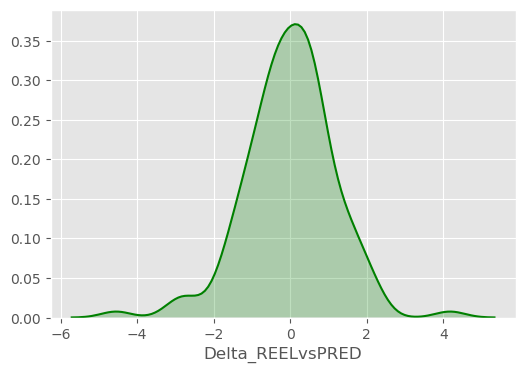

In [539]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2016_pct5_meanDev_pred['Erreur'], hist=False, color="g", kde_kws={"shade": True})

In [531]:
BA_2016_pct5_meanDev_pred_rw150 = pd.DataFrame(BA_2016_pct5_meanDev.iloc[150::])

# Créer une liste de np.arrays de valeurs n=150 d'une fenêtre roulante
r = rolling_window(np.array(BA_2016_pct5_meanDev), 150)

# Init d'une liste de prédictions
pred_col = []

for i in r:
    mod_arma_t = ARIMA(i, order= (1,0,5))
    res_arma_t = mod_arma_t.fit()
    
    # Prédire 1 jour au-delà du dataset
    pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
    # Ajouter la prédiction à la liste
    pred_col.append(pred_arma_t[150]) 
    
BA_2016_pct5_meanDev_pred_rw150['Prediction'] = pred_col[0:-1]
BA_2016_pct5_meanDev_pred_rw150['Erreur'] = BA_2016_pct5_meanDev_pred_rw150['Adj Close'] - BA_2016_pct5_meanDev_pred_rw150['Prediction']


Moyenne du delta Réel vs Prédiction: 0.032 
Écart type du delta Réel vs Prédiction: 1.109
Écart type des données: 2.284


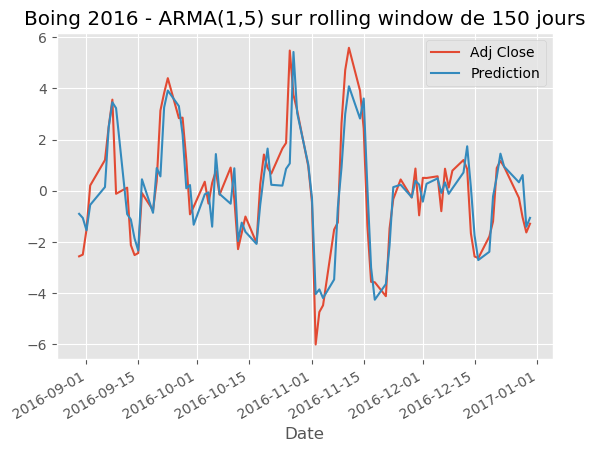

In [660]:
print("Mean Error (Moyenne du delta Réel vs Prédiction): {:.3f} ".format(BA_2016_pct5_meanDev_pred_rw150['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}".format(BA_2016_pct5_meanDev_pred_rw150['Erreur'].std()))
print("Écart type des données: {:.3f}".format(BA_2016_pct5_meanDev_pred_rw150['Adj Close'].std()))
_= BA_2016_pct5_meanDev_pred_rw150[['Adj Close', 'Prediction']].plot()
_= plt.title('Boing 2016 - ARMA(1,5) sur rolling window de 150 jours')

In [540]:
BA_2016_pct5_meanDev_pred_rw150[BA_2016_pct5_meanDev.iloc[:] == np.nan].any()

Adj Close           False
Prediction          False
Delta_REELvsPRED    False
dtype: bool

## Recherche du rolling window optimal

### Rolling window de 25 à 175 par incréments de 25

In [605]:
range1= list(np.arange(25, 176, 25))
ls_mean1= []
ls_std1= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(BA_2016_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('BA_2016_pct5_meanDev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___BA_2016_pct5_variance sur un Rolling window de: 25___
Moyenne du delta Réel vs Prédiction: -0.052 
Écart type du delta Réel vs Prédiction: 1.355
Écart type des données: 2.557
___BA_2016_pct5_variance sur un Rolling window de: 50___
Moyenne du delta Réel vs Prédiction: -0.033 
Écart type du delta Réel vs Prédiction: 1.266
Écart type des données: 2.400
___BA_2016_pct5_variance sur un Rolling window de: 75___
Moyenne du delta Réel vs Prédiction: -0.048 
Écart type du delta Réel vs Prédiction: 1.200
Écart type des données: 2.382
___BA_2016_pct5_variance sur un Rolling window de: 100___
Moyenne du delta Réel vs Prédiction: -0.008 
Écart type du delta Réel vs Prédiction: 1.159
Écart type des données: 2.293
___BA_2016_pct5_variance sur un Rolling window de: 125___
Moyenne du delta Réel vs Prédiction: 0.023 
Écart type du delta Réel vs Prédiction: 1.019
Écart type des données: 2.201
___BA_2016_pct5_variance sur un Rolling window de: 150___
Moyenne du delta Réel vs Prédiction: 0.032 
Écart t

In [627]:
ls_mean1= [-0.052, -0.033, -0.048, -0.008, 0.023, 0.032, 0.034]
ls_std1= [1.355, 1.266, 1.2, 1.159, 1.019, 1.109, 1.138]

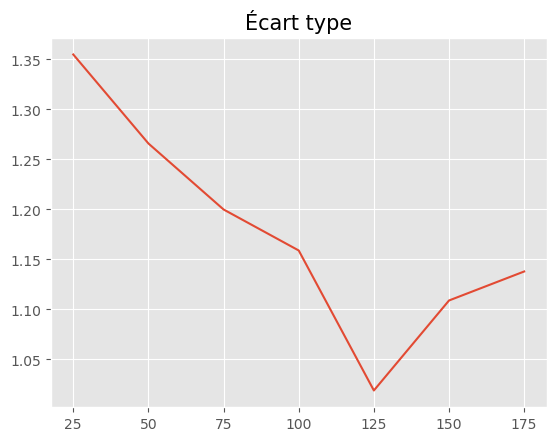

In [631]:
_= plt.plot(range, ls_std1)
_= plt.xticks(range1)
_= plt.title('Écart type: Rollwin 25-175, x25', fontsize= 15)

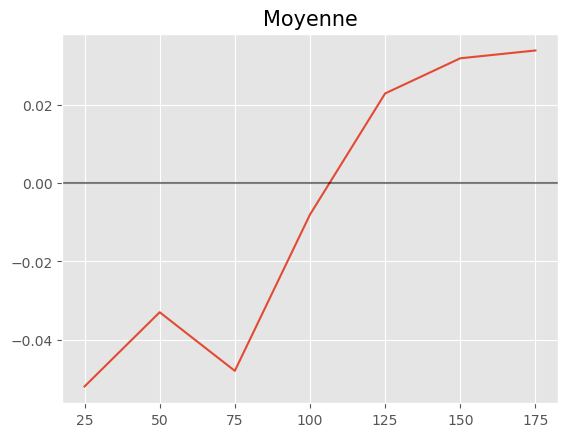

In [634]:

_= plt.plot(range, ls_mean1)
_= plt.xticks(range1)
_= plt.axhline(y= 0, linestyle='-', color='k', alpha= 0.5)
_= plt.title('Moyenne', fontsize= 15)

### Rolling window de 100 à 135 par incréments de 5

In [635]:
range= list(np.arange(100, 136, 5))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(BA_2016_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('BA_2016_pct5_meanDev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___BA_2016_pct5_variance sur un Rolling window de: 100___
Moyenne du delta Réel vs Prédiction: -0.008 
Écart type du delta Réel vs Prédiction: 1.159
Écart type des données: 2.293
___BA_2016_pct5_variance sur un Rolling window de: 105___
Moyenne du delta Réel vs Prédiction: 0.034 
Écart type du delta Réel vs Prédiction: 1.092
Écart type des données: 2.312
___BA_2016_pct5_variance sur un Rolling window de: 110___
Moyenne du delta Réel vs Prédiction: 0.030 
Écart type du delta Réel vs Prédiction: 1.029
Écart type des données: 2.204
___BA_2016_pct5_variance sur un Rolling window de: 115___
Moyenne du delta Réel vs Prédiction: 0.026 
Écart type du delta Réel vs Prédiction: 0.997
Écart type des données: 2.185
___BA_2016_pct5_variance sur un Rolling window de: 120___
Moyenne du delta Réel vs Prédiction: 0.011 
Écart type du delta Réel vs Prédiction: 1.026
Écart type des données: 2.170
___BA_2016_pct5_variance sur un Rolling window de: 125___
Moyenne du delta Réel vs Prédiction: 0.023 
Écart t

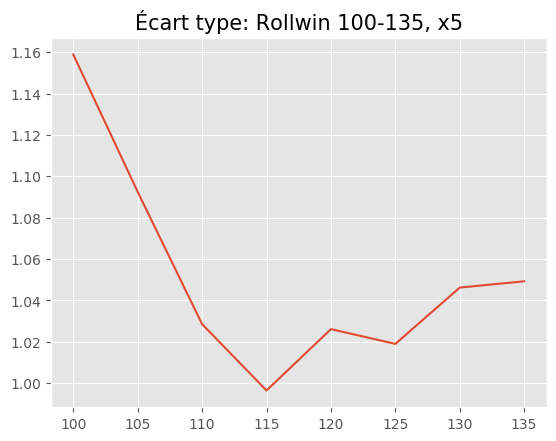

In [639]:
_= plt.plot(range, ls_std)
_= plt.xticks(range)
_= plt.title('Écart type: Rollwin 100-135, x5', fontsize= 15)

### Rollin window de 110 à 125 par incréments de 2

In [640]:
range= list(np.arange(110, 126, 2))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(BA_2016_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('BA_2016_pct5_meanDev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___BA_2016_pct5_variance sur un Rolling window de: 110___
Moyenne du delta Réel vs Prédiction: 0.030 
Écart type du delta Réel vs Prédiction: 1.029
Écart type des données: 2.204
___BA_2016_pct5_variance sur un Rolling window de: 112___
Moyenne du delta Réel vs Prédiction: 0.063 
Écart type du delta Réel vs Prédiction: 1.004
Écart type des données: 2.173
___BA_2016_pct5_variance sur un Rolling window de: 114___
Moyenne du delta Réel vs Prédiction: 0.050 
Écart type du delta Réel vs Prédiction: 1.010
Écart type des données: 2.188
___BA_2016_pct5_variance sur un Rolling window de: 116___
Moyenne du delta Réel vs Prédiction: 0.035 
Écart type du delta Réel vs Prédiction: 0.990
Écart type des données: 2.167
___BA_2016_pct5_variance sur un Rolling window de: 118___
Moyenne du delta Réel vs Prédiction: 0.034 
Écart type du delta Réel vs Prédiction: 0.990
Écart type des données: 2.153
___BA_2016_pct5_variance sur un Rolling window de: 120___
Moyenne du delta Réel vs Prédiction: 0.011 
Écart ty

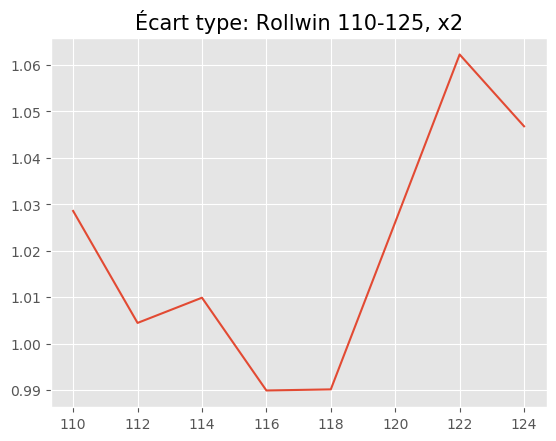

In [806]:
_= plt.plot(range, ls_std)
_= plt.xticks(range)
_= plt.title('Écart type: Rollwin 110-125, x2', fontsize= 15)

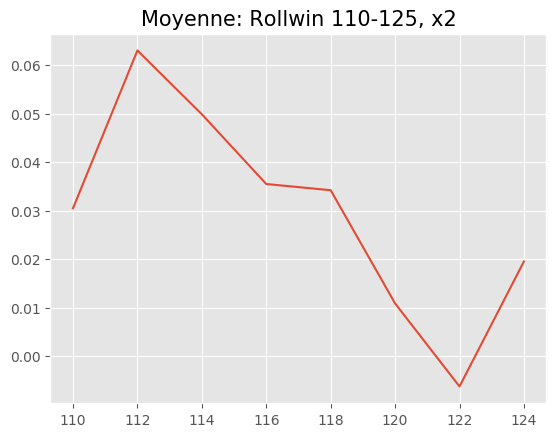

In [642]:
_= plt.plot(range, ls_mean)
_= plt.xticks(range)
_= plt.title('Moyenne: Rollwin 110-125, x2', fontsize= 15)

In [747]:
BA_2016_pct5_meanDev = BA_2016_pct5 - df_ravg_t
BA_2016_pct5_meanDev.dropna(inplace= True)
#BA_2016_pct5_meanDev.head()

In [682]:
df_roll_temp= rolwin_ARIMA(BA_2016_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= 118)

,Adj Close,Prediction,Delta_REELvsPRED
Date,,,
2016-07-15,0.524555,0.598651,-0.074096
2016-07-18,-0.580757,-1.312777,0.732020
2016-07-19,0.834847,-0.624880,1.459727
2016-07-20,1.348351,1.228807,0.119544
2016-07-21,-0.525121,0.791037,-1.316158
...,...,...,...
2016-12-23,0.930929,0.732761,0.198168
2016-12-27,-0.284424,0.181167,-0.465591
2016-12-28,-1.054649,0.431736,-1.486385


In [748]:
df_ravg_t = BA_2016_pct5.rolling(12).mean()
#BA_2016_pct5_meanDev['RollAvg12']= df_ravg_t.loc['2016-07-15': :]
BA_2016_pct5_meanDev= pd.concat([df_roll_temp, df_ravg_t.loc['2016-07-15': :], BA_2016_pct5.loc['2016-07-15': :]], axis= 1)
BA_2016_pct5_meanDev.columns = ['pct5_var', 'Pred_var', 'Erreur', 'RollAvg12_pct5', 'pct5']
# Selon système d'équation résolut sur papier
BA_2016_pct5_meanDev['Pred_pct5'] = BA_2016_pct5_meanDev['pct5'] - BA_2016_pct5_meanDev['Erreur']
#BA_2016_pct5_meanDev['∆_pct5vsPred_pct5'] = BA_2016_pct5_meanDev['pct5'] - BA_2016_pct5_meanDev['Pred_pct5']

In [753]:
BA_2016_pct5_meanDev.head(15)

,pct5_var,Pred_var,Delta_REELvsPRED,RollAvg12_pct5,pct5,Pred_pct5
Date,,,,,,
2016-07-15,0.524555,0.598651,-0.074096,1.243442,1.767997,1.842093
2016-07-18,-0.580757,-1.312777,0.732020,1.633463,1.052705,0.320686
2016-07-19,0.834847,-0.624880,1.459727,2.108357,2.943204,1.483477
2016-07-20,1.348351,1.228807,0.119544,2.194827,3.543177,3.423634
2016-07-21,-0.525121,0.791037,-1.316158,2.030251,1.505131,2.821288
2016-07-22,-1.075963,-0.275380,-0.800583,1.891731,0.815769,1.616352
2016-07-25,-2.216555,-1.983313,-0.233243,1.849317,-0.367238,-0.133996
2016-07-26,-1.705855,-2.855709,1.149854,1.846959,0.141103,-1.008750
2016-07-27,-0.852247,-1.537183,0.684936,1.772658,0.920411,0.235475


Moyenne du delta Réel vs Prédiction: 0.034% 
Écart type du delta Réel vs Prédiction: 0.990%
____________________________
Retour moyen réel: 0.888% 
Retour moyen prédit: 0.854% 
Écart type des retours réels: 2.329%
Écart type des retours prédits: 2.090% 


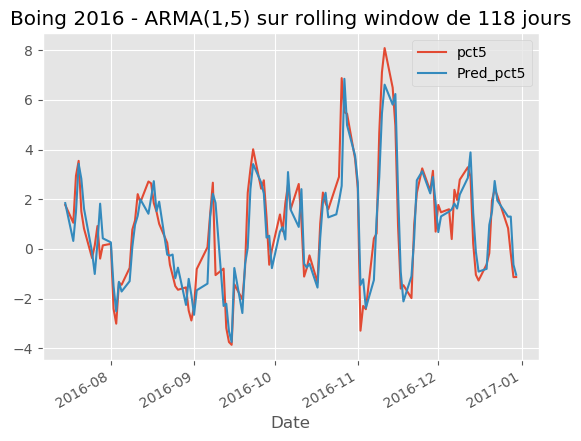

In [750]:
print("Moyenne du delta Réel vs Prédiction: {:.3f}% ".format(BA_2016_pct5_meanDev['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}%".format(BA_2016_pct5_meanDev['Erreur'].std()))
print('____________________________')
print("Retour moyen réel: {:.3f}% ".format(BA_2016_pct5_meanDev['pct5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(BA_2016_pct5_meanDev['Pred_pct5'].mean()))
print("Écart type des retours réels: {:.3f}%".format(BA_2016_pct5_meanDev['pct5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(BA_2016_pct5_meanDev['Pred_pct5'].std()))
_= BA_2016_pct5_meanDev[['pct5', 'Pred_pct5']].plot()
_= plt.title('Boing 2016 - ARMA(1,5) sur rolling window de 118 jours')

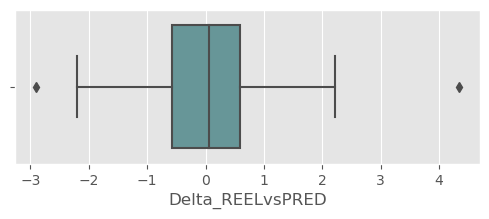

In [795]:
fig= plt.figure(figsize= (6, 2))
_ = sns.boxplot(x= 'Erreur', palette=["cadetblue", "g"],
            data= BA_2016_pct5_meanDev)

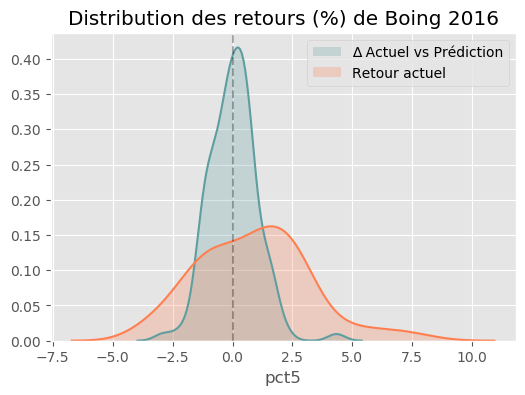

In [802]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2016_pct5_meanDev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(BA_2016_pct5_meanDev['pct5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Boing 2016')

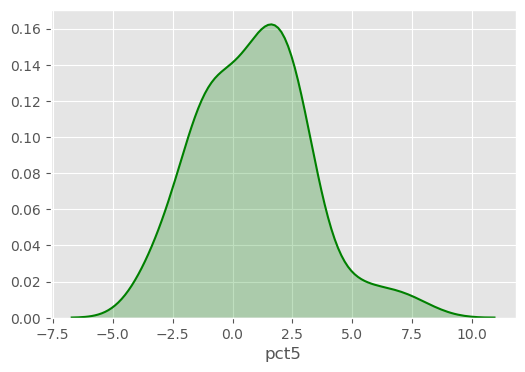

In [782]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2016_pct5_meanDev['pct5'], hist=False, color="g", kde_kws={"shade": True})

In [765]:
BA_2016_pct5_meanDev['Erreur_Dir'] = ((BA_2016_pct5_meanDev['pct5'] < 0) & (BA_2016_pct5_meanDev['Pred_pct5'] > 0)) | ((BA_2016_pct5_meanDev['pct5'] > 0) & (BA_2016_pct5_meanDev['Pred_pct5'] < 0))


In [779]:
BA_2016_pct5_meanDev.head()

,pct5_var,Pred_var,Delta_REELvsPRED,RollAvg12_pct5,pct5,Pred_pct5,BADdir
Date,,,,,,,
2016-07-15,0.524555,0.598651,-0.074096,1.243442,1.767997,1.842093,False
2016-07-18,-0.580757,-1.312777,0.732020,1.633463,1.052705,0.320686,False
2016-07-19,0.834847,-0.624880,1.459727,2.108357,2.943204,1.483477,False
2016-07-20,1.348351,1.228807,0.119544,2.194827,3.543177,3.423634,False
2016-07-21,-0.525121,0.791037,-1.316158,2.030251,1.505131,2.821288,False


In [781]:
BA_2016_pct5_meanDev['Erreur_Dir'].value_counts(normalize= True)

False    0.923729
True     0.076271
Name: BADdir, dtype: float64

In [837]:
forecast_accuracy(BA_2016_pct5_meanDev['Pred_pct5'], BA_2016_pct5_meanDev['pct5'])

{'mape': 1.1706479315037432,
 'me': -0.03420810266274205,
 'mae': 0.7535509894540533,
 'mpe': -0.26136988106430864,
 'rmse': 0.9865811692281357,
 'corr': 0.9051119120393168,
 'minmax': 0.07517506356320258}

## Boing 2016 nutshell

In [853]:
# Tranform to stationary returns with seasonal of 5
BA_2016_pct5 = BA_2016['Adj Close'].pct_change(5)*100
BA_2016_pct5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
BA_2016_pct5_meanDev, df_ravg_temp = tfrm_to_MinusMean(BA_2016_pct5)

# Get temporary df of rolling averages
#df_ravg_temp = BA_2016_pct5.rolling(12).mean()
df_roll_temp= rolwin_ARIMA(BA_2016_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= 118)

# Stiching all together
BA_2016_pct5_meanDev= pd.concat([df_roll_temp, df_ravg_temp.loc['2016-07-15': :], BA_2016_pct5.loc['2016-07-15': :]], axis= 1)
BA_2016_pct5_meanDev.columns = ['pct5_var', 'Pred_var', 'Erreur', 'RollAvg12_pct5', 'pct5']

# Selon système d'équation résolut sur papier
BA_2016_pct5_meanDev['Pred_pct5'] = BA_2016_pct5_meanDev['pct5'] - BA_2016_pct5_meanDev['Erreur']

In [855]:
BA_2016_pct5_meanDev.head()

,pct5_var,Pred_var,Erreur,RollAvg12_pct5,pct5,Pred_pct5
Date,,,,,,
2016-07-15,0.524555,0.598651,-0.074096,1.243442,1.767997,1.842093
2016-07-18,-0.580757,-1.312777,0.732020,1.633463,1.052705,0.320686
2016-07-19,0.834847,-0.624880,1.459727,2.108357,2.943204,1.483477
2016-07-20,1.348351,1.228807,0.119544,2.194827,3.543177,3.423634
2016-07-21,-0.525121,0.791037,-1.316158,2.030251,1.505131,2.821288


In [870]:
BA_2016_pct5_meanDev.shape

(118, 6)

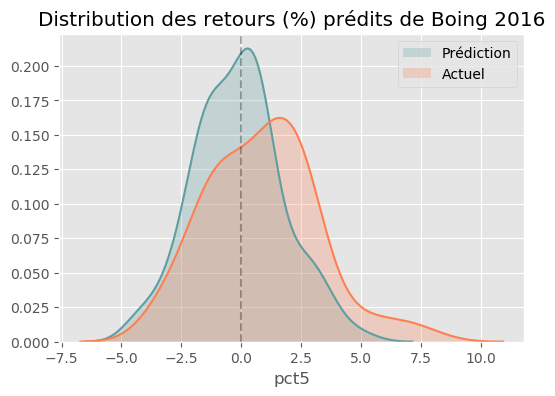

In [860]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2016_pct5_meanDev['Pred_var'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(BA_2016_pct5_meanDev['pct5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('Prédiction', 'Actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) prédits de Boing 2016')

## Test du modèle sur Boing 2017

In [861]:
BA_2017 = BA['2017']
BA_2017_pct5 = BA_2017['Adj Close'].pct_change(5)*100
BA_2017_pct5.dropna(inplace= True)

# Transform to stationary x - rolling mean deviation
BA_2017_pct5_meanDev, df_ravg_temp = tfrm_to_MinusMean(BA_2017_pct5)

# Get temporary df of rolling averages
df_roll_temp= rolwin_ARIMA(BA_2017_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= 118)

In [862]:
# Stiching all together
BA_2017_pct5_meanDev= pd.concat([df_roll_temp, df_ravg_t.loc['2017-07-17': :], BA_2017_pct5.loc['2017-07-17': :]], axis= 1)
BA_2017_pct5_meanDev.columns = ['pct5_var', 'Pred_var', 'Erreur', 'RollAvg12_pct5', 'pct5']
# Selon système d'équation résolut sur papier
BA_2017_pct5_meanDev['Pred_pct5'] = BA_2017_pct5_meanDev['pct5'] - BA_2017_pct5_meanDev['Erreur']

In [863]:
BA_2017_pct5_meanDev

,pct5_var,Pred_var,Erreur,RollAvg12_pct5,pct5,Pred_pct5
Date,,,,,,
2017-07-17,0.958733,0.937723,0.021010,NaN,2.471053,2.450043
2017-07-18,-0.719584,0.115328,-0.834912,NaN,0.955055,1.789967
2017-07-19,0.112272,-0.721730,0.834003,NaN,2.150748,1.316746
2017-07-20,-0.296224,0.451445,-0.747669,NaN,1.963828,2.711497
2017-07-21,-0.541857,-1.141322,0.599465,NaN,1.740927,1.141462
...,...,...,...,...,...,...
2017-12-22,-2.621322,-2.230664,-0.390658,NaN,0.394648,0.785306
2017-12-26,-3.101786,-3.336530,0.234744,NaN,-0.263415,-0.498159
2017-12-27,-2.895185,-2.327062,-0.568123,NaN,-0.548380,0.019743


Moyenne de l'erreur: -0.052% 
Écart type de l'erreur: 1.379%
____________________________
Retour moyen actuel: 1.640% 
Retour moyen prédit: 1.692% 
Écart type des retours actuels: 3.058%
Écart type des retours prédits: 2.773% 


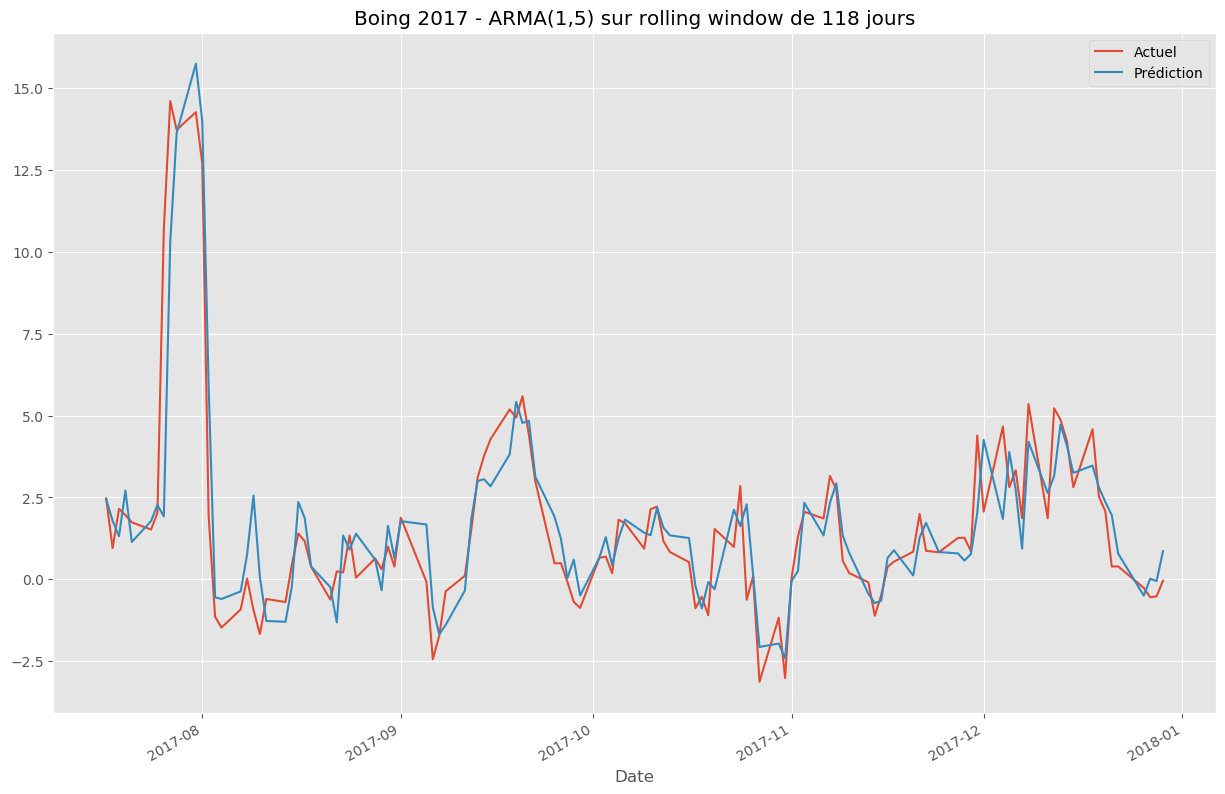

In [885]:
print("Moyenne de l'erreur: {:.3f}% ".format(BA_2017_pct5_meanDev['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(BA_2017_pct5_meanDev['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(BA_2017_pct5_meanDev['pct5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(BA_2017_pct5_meanDev['Pred_pct5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(BA_2017_pct5_meanDev['pct5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(BA_2017_pct5_meanDev['Pred_pct5'].std()))
_= BA_2017_pct5_meanDev[['pct5', 'Pred_pct5']].plot(figsize= [15, 10])
_= plt.legend(('Actuel', 'Prédiction'))
_= plt.title('Boing 2017 - ARMA(1,5) sur rolling window de 118 jours')

In [822]:
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
BA_2017_pct5_meanDev['Erreur_Dir'] = ((BA_2017_pct5_meanDev['pct5'] < 0) & (BA_2017_pct5_meanDev['Pred_pct5'] > 0)) | ((BA_2017_pct5_meanDev['pct5'] > 0) & (BA_2017_pct5_meanDev['Pred_pct5'] < 0))

In [824]:
# Quel est le ratio de prédictions dans la bonne direction (False)
BA_2017_pct5_meanDev['Erreur_Dir'].value_counts(normalize= True)

False    0.880342
True     0.119658
Name: BADdir, dtype: float64

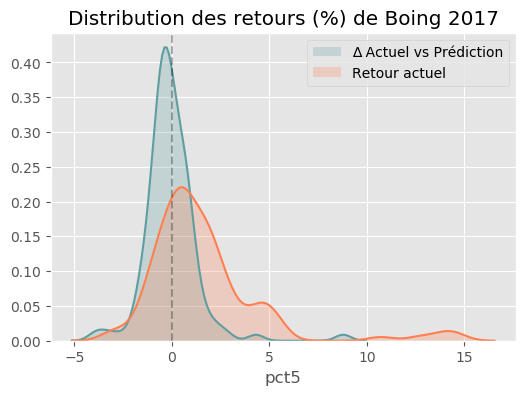

In [825]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2017_pct5_meanDev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(BA_2017_pct5_meanDev['pct5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Boing 2017')

## Test du modèle sur Boing 2018

In [827]:
BA_2018 = BA['2018']
BA_2018_pct5 = BA_2018['Adj Close'].pct_change(5)*100
BA_2018_pct5.dropna(inplace= True)

# Transform to stationary x - rolling mean
BA_2018_pct5_meanDev, df_ravg_temp = tfrm_to_MinusMean(BA_2018_pct5)

df_roll_temp= rolwin_ARIMA(BA_2018_pct5_meanDev, ARIMA_order= (1, 0, 5), window_size= 118)

In [828]:
BA_2018_pct5_meanDev= pd.concat([df_roll_temp, df_ravg_t.loc['2018-07-17': :], BA_2018_pct5.loc['2018-07-17': :]], axis= 1)
BA_2018_pct5_meanDev.columns = ['pct5_var', 'Pred_var', 'Erreur', 'RollAvg12_pct5', 'pct5']
# Selon système d'équation résolut sur papier
BA_2018_pct5_meanDev['Pred_pct5'] = BA_2018_pct5_meanDev['pct5'] - BA_2018_pct5_meanDev['Erreur']
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
BA_2018_pct5_meanDev['Erreur_Dir'] = ((BA_2018_pct5_meanDev['pct5'] < 0) & (BA_2018_pct5_meanDev['Pred_pct5'] > 0)) | ((BA_2018_pct5_meanDev['pct5'] > 0) & (BA_2018_pct5_meanDev['Pred_pct5'] < 0))

Moyenne du delta Réel vs Prédiction: -0.036% 
Écart type du delta Réel vs Prédiction: 1.918%
____________________________
Retour moyen réel: -0.323% 
Retour moyen prédit: -0.279% 
Écart type des retours réels: 4.422%
Écart type des retours prédits: 4.075% 


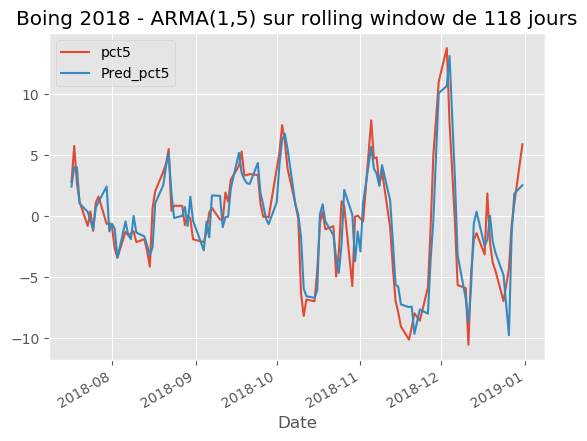

In [829]:
print("Moyenne du delta Réel vs Prédiction: {:.3f}% ".format(BA_2018_pct5_meanDev['Erreur'].mean()))
print("Écart type du delta Réel vs Prédiction: {:.3f}%".format(BA_2018_pct5_meanDev['Erreur'].std()))
print('____________________________')
print("Retour moyen réel: {:.3f}% ".format(BA_2018_pct5_meanDev['pct5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(BA_2018_pct5_meanDev['Pred_pct5'].mean()))
print("Écart type des retours réels: {:.3f}%".format(BA_2018_pct5_meanDev['pct5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(BA_2018_pct5_meanDev['Pred_pct5'].std()))
_= BA_2018_pct5_meanDev[['pct5', 'Pred_pct5']].plot()
_= plt.title('Boing 2018 - ARMA(1,5) sur rolling window de 118 jours'

In [830]:
# Quel est le ratio de prédictions dans la bonne direction (False)
BA_2018_pct5_meanDev['Erreur_Dir'].value_counts(normalize= True)

False    0.777778
True     0.222222
Name: BADdir, dtype: float64

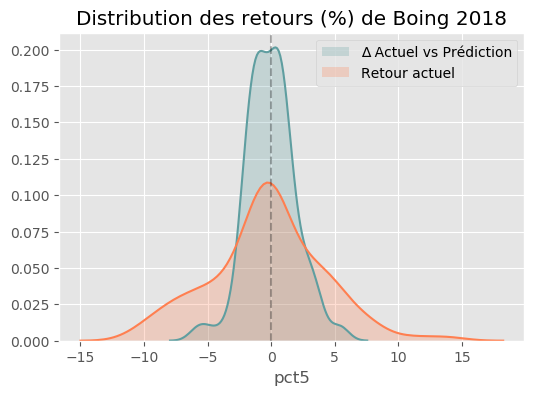

In [831]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(BA_2018_pct5_meanDev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(BA_2018_pct5_meanDev['pct5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Boing 2018')

## Sharpe ratio
mesure du risque - 
return / écart type -
rendement sur

## Boing hors crise (2015 à 2019)

In [117]:
BA_nonCrisis = BA.loc['2016': '2019']

In [48]:
BA_nonCrisis.head()

Date
2016-01-05    0.507286
2016-01-06   -1.993507
2016-01-07   -5.179581
2016-01-08   -2.687652
2016-01-11    0.195808
Name: Adj Close, dtype: float64

### Valeurs différenciées sur interval de 1 jours ("First difference")

In [118]:
BA_nonCrisis1 = BA_nonCrisis['Adj Close'].diff()
BA_nonCrisis1.dropna(inplace= True)

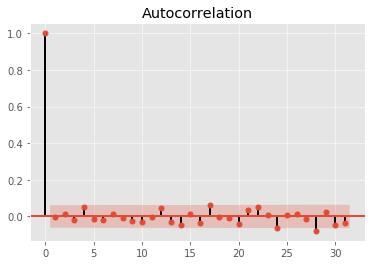

In [119]:
_ = plot_acf(BA_nonCrisis1) # _ = est un truc pour éviter d'imprimer 2x le même plot

### Valeurs différenciées sur interval de 5 jours

In [120]:
BA_nonCrisis5 = BA_nonCrisis['Adj Close'].diff(5)
BA_nonCrisis5.dropna(inplace= True)

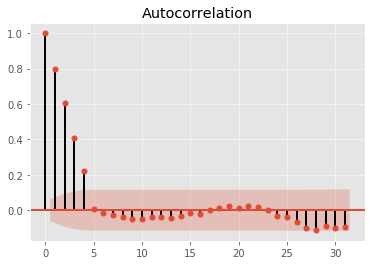

In [121]:
_ = plot_acf(BA_nonCrisis5) # _ = est un truc pour éviter d'imprimer 2x le même plo5

In [67]:
BA_nonCrisis4.autocorr()

0.7617474221452258

In [65]:
BA_nonCrisis10 = BA_nonCrisis['Adj Close'].diff(10)
BA_nonCrisis10.dropna(inplace= True)

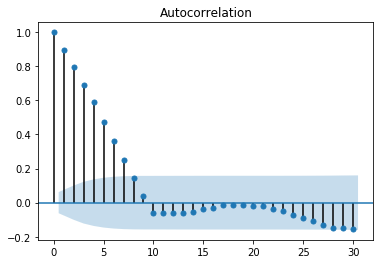

In [66]:
_ = plot_acf(BA_nonCrisis10) # _ = est un truc pour éviter d'imprimer 2x le même plot

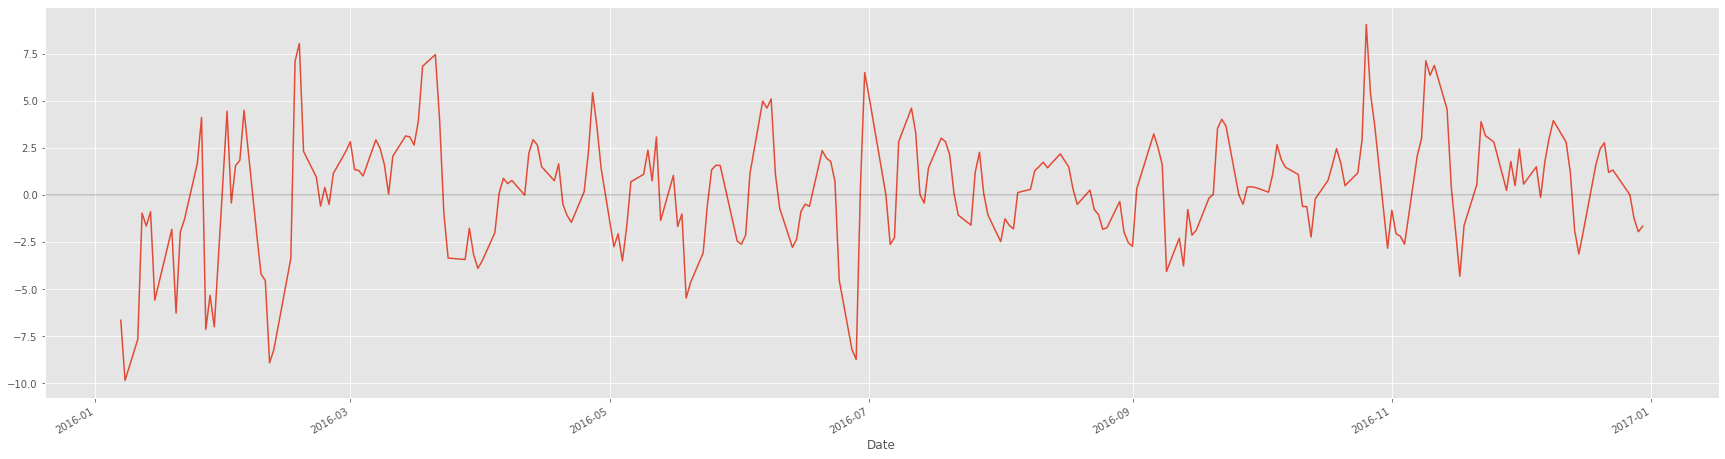

In [16]:
BA_2016_diff3 = BA_2016['Adj Close'].diff(3)
BA_2016_diff3.dropna(inplace= True)
_ = BA_2016_diff3.plot(figsize= [30, 8])
_ = plt.axhline(y= 0, linestyle='-', color='k', alpha= 0.2)

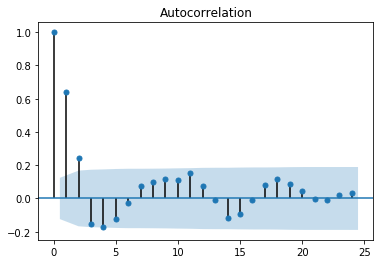

In [61]:
_ = plot_acf(BA_2016_diff3) # _ = est un truc pour éviter d'imprimer 2x le même plot

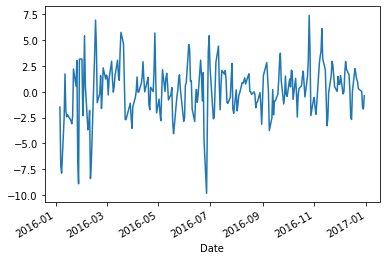

In [24]:
BA_2016_diff2 = BA_2016['Adj Close'].diff(2)
BA_2016_diff2.plot()

In [871]:
BA_2017b = BA['2017']
BA_2017_pct5b = BA_2017b['Adj Close'].pct_change(5)*100
BA_2017_pct5b.dropna(inplace= True)



In [872]:
BA_2017_pct5b

Date
2017-01-10    1.337829
2017-01-11    0.491712
2017-01-12   -0.264657
2017-01-13   -0.169730
2017-01-17   -0.410553
                ...   
2017-12-22    0.394648
2017-12-26   -0.263415
2017-12-27   -0.548380
2017-12-28   -0.520299
2017-12-29   -0.040670
Name: Adj Close, Length: 246, dtype: float64

In [ ]:
# Transform to stationary x - rolling mean deviation
BA_2017_pct5_meanDevB, df_ravg_tempB = tfrm_to_MinusMean(BA_2017_pct5b)

In [883]:
BA_2017_pct5b['test'] = np.nan

In [884]:
BA_2017_pct5b

Date
2017-01-10 00:00:00      1.33783
2017-01-11 00:00:00     0.491712
2017-01-12 00:00:00    -0.264657
2017-01-13 00:00:00     -0.16973
2017-01-17 00:00:00    -0.410553
                         ...    
2017-12-26 00:00:00    -0.263415
2017-12-27 00:00:00     -0.54838
2017-12-28 00:00:00    -0.520299
2017-12-29 00:00:00   -0.0406702
test                         NaN
Name: Adj Close, Length: 247, dtype: object